# Quick Start: Iterating over splits of gift-eval datasets
First lets check the names of all the datasets in the `gift-eval` directory.

Make sure you download the gift-eval benchmark and set the `GIFT-EVAL` environment variable correctly before running this notebook.



In [17]:
from gift_eval.data import Dataset

import os
from dotenv import load_dotenv
from pathlib import Path

# Load environment variables
load_dotenv()

# Get the GIFT_EVAL path from environment variables
gift_eval_path = os.getenv('GIFT_EVAL')

if gift_eval_path:
    # Convert to Path object for easier manipulation
    gift_eval_path = Path(gift_eval_path)
    
    # Get all subdirectories (dataset names) in the GIFT_EVAL path
    dataset_names = []
    for dataset_dir in gift_eval_path.iterdir():
        if dataset_dir.name.startswith("."):
            continue
        if dataset_dir.is_dir():
            freq_dirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
            if freq_dirs:
                for freq_dir in freq_dirs:
                    dataset_names.append(f"{dataset_dir.name}/{freq_dir.name}")
            else:
                dataset_names.append(dataset_dir.name)
    
    print("Available datasets in GIFT_EVAL:")
    for name in sorted(dataset_names):
        print(f"- {name}")
else:
    print("GIFT_EVAL path not found in environment variables. Please check your .env file.")


Available datasets in GIFT_EVAL:
- LOOP_SEATTLE/5T
- LOOP_SEATTLE/D
- LOOP_SEATTLE/H
- M_DENSE/D
- M_DENSE/H
- SZ_TAXI/15T
- SZ_TAXI/H
- bitbrains_fast_storage/5T
- bitbrains_fast_storage/H
- bitbrains_rnd/5T
- bitbrains_rnd/H
- bizitobs_application
- bizitobs_l2c/5T
- bizitobs_l2c/H
- bizitobs_service
- car_parts_with_missing
- covid_deaths
- electricity/15T
- electricity/D
- electricity/H
- electricity/W
- ett1/15T
- ett1/D
- ett1/H
- ett1/W
- ett2/15T
- ett2/D
- ett2/H
- ett2/W
- hierarchical_sales/D
- hierarchical_sales/W
- hospital
- jena_weather/10T
- jena_weather/D
- jena_weather/H
- kdd_cup_2018_with_missing/D
- kdd_cup_2018_with_missing/H
- m4_daily
- m4_hourly
- m4_monthly
- m4_quarterly
- m4_weekly
- m4_yearly
- restaurant
- saugeenday/D
- saugeenday/M
- saugeenday/W
- solar/10T
- solar/D
- solar/H
- solar/W
- temperature_rain_with_missing
- us_births/D
- us_births/M
- us_births/W
- wiki


# Loading Datasets

We provide a simple class, called `Dataset`, to load each dataset in our benchmark following the gluonts interface. It is highly recommended to use this class to split the data to train/val/test for compatibility with the evaluation framework and other baselines in the leaderboard. You don't have to stick to gluonts interface though as you can easily implement a wrapper class to load the data iterator in a different format than gluonts.

This class provides the following properties:

- `training_dataset`: The training dataset.
- `validation_dataset`: The validation dataset.
- `test_data`: The test dataset.

Note that timeseries modality splits the data to train/val/test on the time dimension rather than the series dimension. Thus each of these splits utilize same series but different time indices. The number of windows for rolling evaluation is determined by the `Dataset` class. 

The training_dataset and validation_dataset are iterators where each element is a dictionary with the following keys:

- `start`: the start time of the window
- `target`: the target values of the window
- `item_id`: the id of the series
- `freq`: The frequency of the series
- `past_feat_dynamic_real`: [If exists] the past feature dynamic real values of the window


The test_data is a tuple with two dictionaries. First for the context, second for the forecast horizon, where each dictionary contains the same keys as above.


## Example Usage: M4 Monthly

Lets load and inspect the M4 Monthly dataset using our `Dataset` class.

In [11]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

ds_name = "m4_monthly" # Name of the dataset
to_univariate = False # Whether to convert the data to univariate
term = "short" # Term of the dataset

dataset = Dataset(name=ds_name, term=term,to_univariate=to_univariate)
print("Dataset frequency: ",dataset.freq)
print("Prediction length: ",dataset.prediction_length)
print("Number of windows in the rolling evaluation: ",dataset.windows)

Dataset frequency:  M
Prediction length:  18
Number of windows in the rolling evaluation:  1


Keys in the training data:  dict_keys(['item_id', 'start', 'freq', 'target'])
Item id:  0
Start Date:  1750-01
Frequency:  M
Last 10 target values:  [ 7860.  7150.  8110. 10860. 10730.  9610.  8270.  9200.  6660.  6270.]


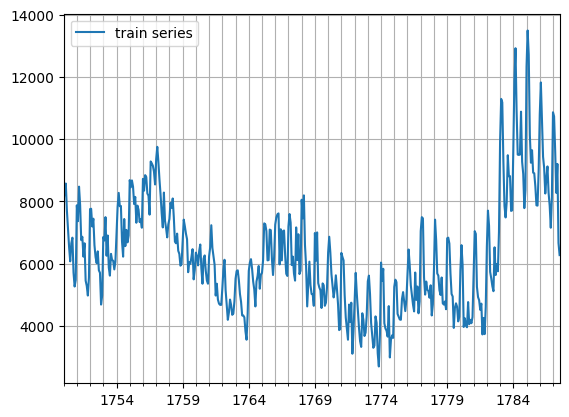

In [20]:
train_data_iter = dataset.training_dataset # Get the training data iterator

train_data = next(iter(train_data_iter))
print("Keys in the training data: ", train_data.keys())

print("Item id: ", train_data["item_id"])
print("Start Date: ", train_data["start"])
print("Frequency: ", train_data["freq"])
print("Last 10 target values: ", train_data["target"][-10:])


train_series = to_pandas(train_data)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

Keys in the validation data:  dict_keys(['item_id', 'start', 'freq', 'target'])
Item id:  0
Start Date:  1750-01
Frequency:  M
Last 10 target values:  [6050. 5640. 6220. 5740. 6040. 5130. 5090. 5210. 4910. 6890.]


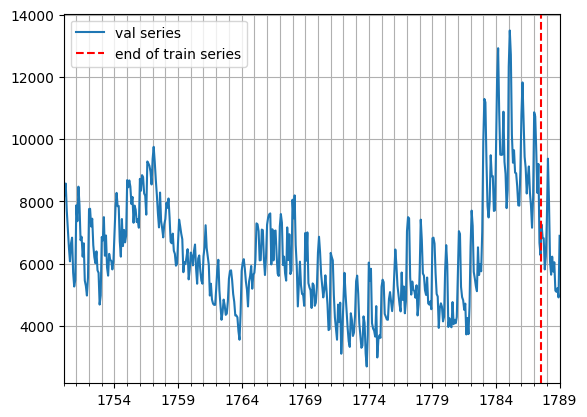

In [21]:
val_data_iter = dataset.validation_dataset

val_data = next(iter(val_data_iter))
print("Keys in the validation data: ", val_data.keys())

print("Item id: ", val_data["item_id"])
print("Start Date: ", val_data["start"])
print("Frequency: ", val_data["freq"])
print("Last 10 target values: ", val_data["target"][-10:])

val_series = to_pandas(val_data)
val_series.plot()
plt.grid(which="both")
# Add a vertical axis for where the train series ends
plt.axvline(x=train_series.index[-1], color='r', linestyle='--', label='End of train series')
plt.legend(["val series", "end of train series"], loc="upper left")
plt.show()

Keys in the test data:  dict_keys(['item_id', 'start', 'freq', 'target'])


Context Item id:  0
Context Start Date:  1750-01
Context Frequency:  M
Context Last 10 target values:  [6050. 5640. 6220. 5740. 6040. 5130. 5090. 5210. 4910. 6890.]


Forecast Item id:  0
Forecast Start Date:  1789-02
Forecast Frequency:  M
Forecast Last 10 target values:  [6560. 4900. 4520. 7370. 9050. 7780. 5380. 4700. 4490. 4010.]


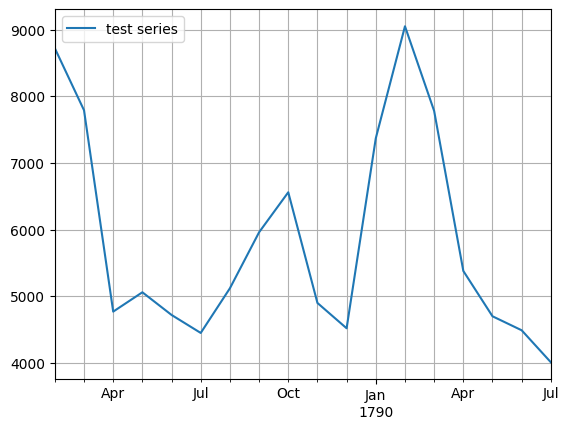

In [27]:
test_split_iter = dataset.test_data

test_data = next(iter(test_split_iter))
print("Keys in the test data: ", test_data[0].keys())

print("\n\nContext Item id: ", test_data[0]["item_id"])
print("Context Start Date: ", test_data[0]["start"])
print("Context Frequency: ", test_data[0]["freq"])
print("Context Last 10 target values: ", test_data[0]["target"][-10:])

print("\n\nForecast Item id: ", test_data[1]["item_id"])
print("Forecast Start Date: ", test_data[1]["start"])
print("Forecast Frequency: ", test_data[1]["freq"])
print("Forecast Last 10 target values: ", test_data[1]["target"][-10:])

test_series = to_pandas(test_data[1])
test_series.plot()
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

